In [ ]:
import os
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2

import platform

In [ ]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/Thesis/Lorenz/')
print(os.getcwd())

/content/drive/MyDrive/Colab Notebooks/Thesis/Lorenz


In [ ]:
# setting seed for PRNGs
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
tf.test.gpu_device_name()
tf.__version__

'2.8.2'

In [ ]:
from tools.misc_tools import create_Lorenz_data

In [ ]:
# setting up params

from numpy import *

### Simutlation paramaters
dir_name_rnn = os.getcwd()+'/saved_rnn/rnn_000'
with open(dir_name_rnn + '/sim_data_AE_params.txt') as f:
    lines = f.readlines()

params_dict = eval(''.join(lines))

dir_name_ae = params_dict['dir_name_ae']
ae_idx = dir_name_ae[-3:]

rho_arr = params_dict['rho_arr']
sigma_arr = params_dict['sigma_arr']
beta_arr = params_dict['beta_arr']

x0 = params_dict['x0']
y0 = params_dict['y0']
z0 = params_dict['z0']

t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']

normalize_flag = params_dict['normalize_flag']


### RNN paramaters
with open(dir_name_rnn + '/RNN_specific_data.txt') as f:
    lines = f.readlines()

params_rnn_dict = eval(''.join(lines))

dt_rnn = params_rnn_dict['dt_rnn']
T_sample_input = params_rnn_dict['T_sample_input']
T_sample_output = params_rnn_dict['T_sample_output']
T_offset = params_rnn_dict['T_offset']
return_params_arr = params_rnn_dict['return_params_arr']

In [ ]:
res_dict = create_Lorenz_data(
    T, t0, delta_t,
    rho_arr, sigma_arr, beta_arr,
    x0, y0, z0, return_params_arr=return_params_arr,
    normalize=normalize_flag
)

all_data = res_dict['all_data']
N = res_dict['N']
boundary_idx_arr = res_dict['boundary_idx_arr']

if return_params_arr == True:
    params_arr = res_dict['params_arr']

if normalize_flag == True:
    normalization_constant_arr = res_dict['normalization_constant_arr']

In [ ]:
n = len(boundary_idx_arr)

# Autoencoder

In [ ]:
from tools.ae_v3 import Autoencoder

In [ ]:
# load_file = dir_name_ae+dir_sep+'new_class_data'+dir_sep+'ae_'+ae_idx+'_class_dict.txt'
# wt_file = dir_name_ae+dir_sep+'new_class_data'+dir_sep+'ae_'+ae_idx+'_ae_weights.h5'

load_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_class_dict.txt'
wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'

In [ ]:
ae_net = Autoencoder(6, load_file=load_file)
ae_net.load_weights_from_file(wt_file)

In [ ]:
# create data
latent_states_all = ae_net.encoder_net.predict(all_data)

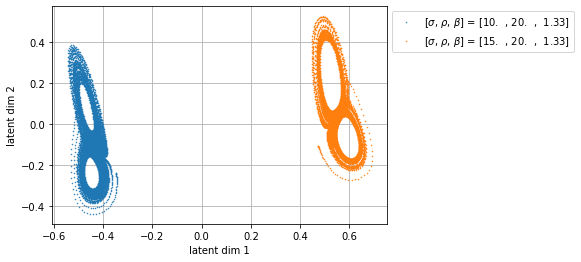

In [ ]:
# plotting latent states
prev_idx = 0
# plt_idx = 27
# for i in range(plt_idx,plt_idx+1):
for i in range(len(boundary_idx_arr)):
    next_idx = boundary_idx_arr[i]
    plt.plot(
        latent_states_all[prev_idx:next_idx, 0],
        latent_states_all[prev_idx:next_idx, 1],
        linewidth=0,
        marker='.',
        color='C'+str(i),
        markersize=1,
#         label=r'[$\sigma$, $\rho$, $\beta$] = ' + str(all_data[next_idx-1, 3:])
        label=r'[$\sigma$, $\rho$, $\beta$] = ' + np.array2string(all_data[next_idx-1, 3:], precision=2, separator=', ')
    )
    prev_idx = next_idx

# plt.xlim([-1,1])
# plt.ylim([-1,1])
plt.grid(True)
plt.xlabel('latent dim 1')
plt.ylabel('latent dim 2')
max_rows = 10
ncols = 1 + len(boundary_idx_arr) // max_rows
plt.legend(bbox_to_anchor=(1,1), ncol=ncols)
# plt.savefig(dir_name_ae+'/plots/latent_space.png', dpi=300, bbox_inches='tight')
plt.show()

# LSTM

In [ ]:
from tools.LSTM_SingleStep_v1 import RNN_LSTM

In [ ]:
# # Training parameters
# learning_rate_list = [0.001, 0.0001, 0.00001]
# epochs = 2000
# patience = 20  # parameter for early stopping
# min_delta = 1e-5  # parameter for early stopping
# lambda_reg = 1e-5  # weight for regularizer

# rnn_layers_units = [8, 8, 8]

# rnn_net = RNN_LSTM(
#     data_dim=2,
# #     in_steps=int(T_sample_input // dt_rnn),
# #     out_steps=int(T_sample_output // dt_rnn),
#     dt_rnn=dt_rnn,
#     lambda_reg=lambda_reg,
#     reg_name='L2',
#     rnn_layers_units=rnn_layers_units,
#     dense_layer_act_func='linear',
#     load_file=None
# )

In [ ]:
rnn_net = RNN_LSTM(load_file=dir_name_rnn+'{ds}final_net{ds}final_net_class_dict.txt'.format(ds=dir_sep))
temp = rnn_net.predict(tf.ones(shape=[1, 1, rnn_net.data_dim]))
rnn_net.load_weights_from_file(file_name=dir_name_rnn+'{ds}final_net{ds}final_net_lstm_weights.h5'.format(ds=dir_sep))

In [ ]:
# for rnn_layer in rnn_net.rnn_layers_list:
#     rnn_layer.return_state = True

In [ ]:
# temp = rnn_net(tf.ones(shape=[1, 1, 2]))
# rnn_net.load_weights(dir_name_rnn+'{ds}checkpoints{ds}checkpoints.index'.format(ds=dir_sep))

# # new_net = tf.keras.models.load_model(dir_name_rnn + '{ds}checkpoints'.format(ds=dir_sep))

In [ ]:
# rnn_net.save_everything(file_name=dir_name_rnn+'{ds}final_net'.format(ds=dir_sep))

# Autoregressive RNN

In [ ]:
from tools.Autoregressive_RNN_v1 import Autoregressive_RNN

In [ ]:
AR_RNN = Autoregressive_RNN(SingleStepLSTM_model=rnn_net)

In [ ]:
AR_RNN.SingleStepLSTM_model.dt_rnn

0.25

# AE-RNN

In [ ]:
from tools.misc_tools import create_data_for_RNN
from tools.AE_RNN_v2 import AE_RNN

In [ ]:
ae_rnn = AE_RNN(
    encoder_net=ae_net.encoder_net,
    decoder_net=ae_net.decoder_net,
    rnn_net=AR_RNN
)

In [ ]:
dt_rnn = rnn_net.dt_rnn
T_input = dt_rnn
T_output = 30
T_offset = dt_rnn
params = None

# data_rnn_input, data_rnn_output, org_data_idx_arr_input, org_data_idx_arr_output = create_data_for_RNN(
#     latent_states_all,
#     dt_rnn,
#     T_sample_input,
#     T_sample_output,
#     T_offset,
#     N,
#     boundary_idx_arr,
#     delta_t,
#     params=params)

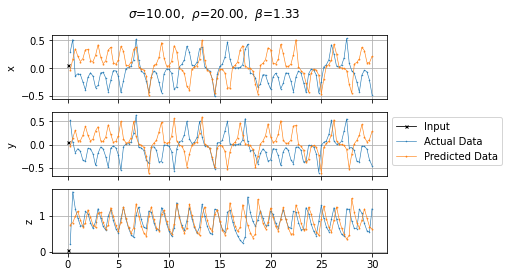

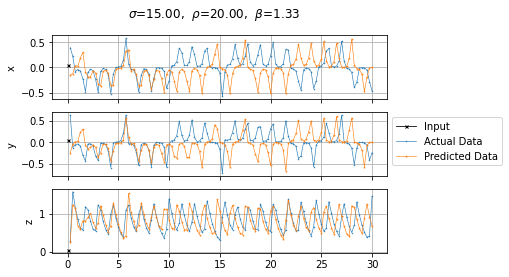

In [ ]:
n = len(boundary_idx_arr)

# T_input = dt_rnn
# T_output = 25
num_input = int(T_input // dt_rnn)
num_output = int(T_output // dt_rnn)
idx_to_skip = int(dt_rnn // delta_t)

save_dir = dir_name_rnn+dir_sep+'plots'+dir_sep+'AE_RNN'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

num_digits_n = int(np.log10(n)+1)

for i in range(len(boundary_idx_arr)):
    u_input = all_data[i*(N+1)+0:i*(N+1)+0 + idx_to_skip*num_input:idx_to_skip, :].reshape(1, num_input, 6)
    output_exact = all_data[(N+1)*i+idx_to_skip*num_input:i*(N+1)+ idx_to_skip*(num_input+num_output):idx_to_skip]
    if return_params_arr is not True:
        params = None
    else:
        params = params_arr[i, :]
        
    output_predicted = ae_rnn.predict(inputs=u_input, out_time=T_output, training=False, params=params)


    fig, ax = plt.subplots(3, 1, sharex=True)
    ax_ylabels = ['x', 'y', 'z']
    ax_plots = [None]*3
    for j in range(3):
        input_time = np.arange(0,dt_rnn*num_input, dt_rnn)
        output_time = np.arange(input_time[-1]+dt_rnn, input_time[-1]+dt_rnn + dt_rnn*num_output, dt_rnn)
        
        ax_plots[0] = ax[j].plot(input_time, u_input[0, :, j], marker='x', color='k', markersize=3, linewidth=0.8)#, label='_nolegend_')
        ax_plots[1] = ax[j].plot(output_time, output_exact[:, j], marker='.', linewidth=0.6, markersize=1)#, label='Actual Data')
        ax_plots[2] = ax[j].plot(output_time, output_predicted[0, :, j], marker='^', linewidth=0.6, markersize=1)#, label='Predicted Data')
        
#         ax[j].legend()
        if j == 1:
            ax[j].legend(labels=['Input', 'Actual Data', 'Predicted Data'], bbox_to_anchor=(1,1))
        ax[j].grid()
        ax[j].set_ylabel(ax_ylabels[j])
        
    fig.suptitle(r'$\sigma$={:.2f},  $\rho$={:.2f},  $\beta$={:.2f}'.format(all_data[i*(N+1), 3], all_data[i*(N+1), 4], all_data[i*(N+1), 5]))
#     fig.legend(labels=['Input', 'Actual Data', 'Predicted Data'], bbox_to_anchor=(1.2,0.5))
    plt.savefig(save_dir+dir_sep+'AE_RNN-prediction-{}.png'.format(str(i+1).zfill(num_digits_n)), dpi=300, bbox_inches='tight')